In [44]:
import pandas as pd 
import numpy as np
import os 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import scipy.stats as sp_stats

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [77]:
bar_figures_dir = "figures/analyte_bar"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
HWDC_bar_palette={"A":"#FEACA7","B":"#D4D4D4"}
HWDC_point_palette={"A":"#FF2804","B":"#000000"}

def sig_str_from_p(pval):
    if pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    else:
        return ""
    
def tissue_analyte_long_df(data_df,analytes,tissues,sampleID_col,A_group_re=r'AF|AM'):
    """Generate long form DataFrame with Measurement (numerical) and Analyte and Tissue (categorical) columns
    """
    long_columns = [sampleID_col,"Measurement","Analyte","Tissue"]
    if "Cluster" in data_df.columns:
        long_columns.extend(["Cluster"])
    long_df = pd.DataFrame(columns=long_columns)
    for tissue in tissues: 
        for analyte in analytes: 
            #Partition input dataframe
            if "Tissue" in data_df.columns: 
                tissue_data = data_df.loc[data_df["Tissue"]==tissue] #important for multiple analytes/tissues case
            else:
                tissue_data = data_df #single analyte case (usually)
            A_data = tissue_data.loc[tissue_data[sampleID_col].str.contains(A_group_re),analyte]
            B_data = tissue_data.loc[~tissue_data[sampleID_col].str.contains(A_group_re),analyte]
            
            tissue_short_df = pd.DataFrame(index=tissue_data.index,columns=long_df.columns)
            #Populate long form data for seaborn 
            tissue_short_df.loc[:,sampleID_col] = tissue_data[sampleID_col]
            tissue_short_df.loc[A_data.index,"Measurement"] = A_data 
            tissue_short_df.loc[A_data.index,"Group"] = ["A"]*len(A_data.index)
            tissue_short_df.loc[A_data.index,"Tissue"] = [tissue]*len(A_data.index)
            tissue_short_df.loc[A_data.index,"Analyte"] = [analyte]*len(A_data.index)
            tissue_short_df.loc[B_data.index,"Measurement"] = B_data 
            tissue_short_df.loc[B_data.index,"Group"] = ["B"]*len(B_data.index)
            tissue_short_df.loc[B_data.index,"Tissue"] = [tissue]*len(B_data.index)
            tissue_short_df.loc[B_data.index,"Analyte"] = [analyte]*len(B_data.index)
            if "Cluster" in data_df.columns:
                tissue_short_df.loc[A_data.index,"Cluster"] = tissue_data.loc[A_data.index,"Cluster"]
                tissue_short_df.loc[B_data.index,"Cluster"] = tissue_data.loc[B_data.index,"Cluster"]
            
            long_df = pd.concat([long_df,tissue_short_df],ignore_index=True)
    long_df.dropna(how="all",inplace=True)        
    return long_df

def single_analyte_stats(data_df,analyte_col,tissue,sampleID_col,A_group_re=r'AF|AM',stats_test="Mann-Whitney",
                        split="arm",B_group_re=""):
    if "Tissue" in data_df.columns:
        data_df = data_df.loc[data_df["Tissue"]==tissue] #subset to tissue if tissue in data_df columns, otherwise ignore  
    else:
        pass 
    if split == "arm":
        A_data = data_df.loc[data_df[sampleID_col].str.contains(A_group_re),analyte_col]
        if B_group_re: #specify B group if more than 2 groups 
            B_data = data_df.loc[data_df[sampleID_col].str.contains(B_group_re),analyte_col]
        else:
            B_data = data_df.loc[~data_df[sampleID_col].str.contains(A_group_re),analyte_col] 
        if stats_test == "Mann-Whitney":
            stat, pval = sp_stats.mannwhitneyu(x=A_data,y=B_data,alternative="two-sided")
    elif split == "cluster":
        assert "Cluster" in data_df.columns,"split='cluster' but 'Cluster' column not provided in data_df"
        assert len(data_df["Cluster"].unique())==2,"Cannot assign stats for more than one group"
        cluster_labels = list(data_df["Cluster"].unique())
        cluster1 = data_df.loc[data_df["Cluster"]==cluster_labels[0],analyte_col]
        cluster2 = data_df.loc[data_df["Cluster"]==cluster_labels[1],analyte_col]
        if stats_test == "Mann-Whitney":
            stat, pval = sp_stats.mannwhitneyu(x=cluster1,y=cluster2,alternative="two-sided")
    sig_str = sig_str_from_p(pval)
    return stat, pval, sig_str 

def multiple_analyte_stats(data_df,analytes,tissues,sampleID_col,A_group_re=r'AF|AM',stats_test="Mann-Whitney"):
    stats_columns = ["Analyte","Tissue","stat","pval","sig_str"]
    stats_df = pd.DataFrame(columns=stats_columns)
    i = 0 
    for analyte in analytes:
        for tissue in tissues: 
            stat,pval,sig_str = single_analyte_stats(data_df,analyte,tissue,sampleID_col,
                                                    A_group_re=A_group_re,stats_test=stats_test)
            row_srs = pd.Series(dict(zip(stats_columns,[analyte,tissue,stat,pval,sig_str])))
#             display(row_srs)
            stats_df.loc[i,:] = row_srs
            i+=1 
    return stats_df

def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title(title,weight="bold",fontsize=title_size)

def significance_bracket(ax,pval,sig_str,sigstr_fmt="std",x1=0,x2=0,y1=0,y2=0):
    #Determining coordinates for brackets and sig_str
    ymin, ymax = ax.get_ylim()
    ydiff = ymax-ymin
    xticks = ax.get_xticks()
    if x1 == 0 and x2 == 0: #Default to first two xticks (ie single analyte situation) if x1/x2 not provided
        x1, x2 = xticks[0], xticks[1]
    if y1 == 0 and y2 == 0:
        y2 = ymax - (ydiff)*0
        y1 = y2-(ydiff)*.01
    #Plot significance bracket and sig_str; different cases for sigstr_fmt (ie ns/* format vs pval=...)
    if sigstr_fmt == "std":
        if sig_str == "":
            sig_str = "ns"
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        elif "*" in sig_str:
            #Positioning for * format sig_str
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        else: 
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    elif sigstr_fmt == "pval": #Annotation text is of form p=x.xxx
        pval_str = "p={:.3f}".format(pval)
        plt.text((x1+x2)*.5, y2+ydiff*0.01, pval_str, ha='center', va='bottom', color='k',weight="bold")
        plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    else: #Default behavior, don't add bracket/sigstr 
        pass
#Single metabolite barplot generation 
def single_analyte_barplot(data_df,analyte,tissue,A_group_re=r'AF|AM',sampleID_col="SampleID",
                           ax=None,units="µM",legend=True,stats_test="Mann-Whitney",sigstr_fmt="std",
                          split="arm",fig_fmt="png"):
    
    #stats test results 
    stat,pval,sig_str = single_analyte_stats(data_df,analyte,tissue,sampleID_col=sampleID_col,
                                              stats_test=stats_test,split=split)
    #Generate long form data for seaborn 
    tissue_analyte_df = tissue_analyte_long_df(data_df,[analyte],[tissue],sampleID_col=sampleID_col,
                                               A_group_re=A_group_re)
#     display(tissue_analyte_df)
    if not ax:
        new_fig = True
        fig,ax = plt.subplots(1,1,figsize=(1,6))
    else: 
        new_fig = False

    #Overlay swarmplot over barplot of individual sample data 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if split == "arm":
            sns.barplot(data=tissue_analyte_df,x="Group",y="Measurement",ax=ax,zorder=0,palette=HWDC_bar_palette,
                        capsize=0.1,errwidth=1)
            sns.swarmplot(data=tissue_analyte_df,x="Group",y="Measurement", ax=ax, zorder=1,palette=HWDC_point_palette)
        elif split == "cluster":
            sns.barplot(data=tissue_analyte_df,x="Cluster",y="Measurement",ax=ax,zorder=0,palette=HWDC_bar_palette,
                        capsize=0.1,errwidth=1)
            sns.swarmplot(data=tissue_analyte_df,x="Cluster",y="Measurement", ax=ax, zorder=1,palette=HWDC_point_palette)
    #spaghetti code for changing error bar hues on seaborns barplot 
    face_colors = list(HWDC_bar_palette.values())
    point_colors = list(HWDC_point_palette.values())
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        newcolor = point_colors[i//lines_per_err]
        line.set_color(newcolor)
    #Matplotlib formatting 
    #Add units to ylabel
#     tissue = tissue.title() #Title String capitalization bc we classy 
    tissue = tissue.replace("_"," ")
    ax.set_ylabel("{0} ({1})".format(analyte,units),fontsize=12,fontweight="bold")
    ax.set_xlabel(tissue,labelpad=10,fontsize=12,fontweight="bold")
    
    significance_bracket(ax,pval,sig_str,sigstr_fmt=sigstr_fmt)
    #bold xtick/yticks
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    ax.set_xticks([])#Remove xticks (will just show A/B group labels)
    
    if new_fig:
        #Add title, legend to new plot 
        title_str = "{0}\n{1}".format(analyte,tissue)
        ax.set_title(title_str,fontsize=14,fontweight="bold")
        if legend:
            A_patch = matplotlib.patches.Patch(color=face_colors[0], label='Prevotella')
            B_patch = matplotlib.patches.Patch(color=face_colors[1], label='No Prevotella')
            plt.legend(handles=[A_patch,B_patch])
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
        
        analyte_path_str = analyte.replace('/','.')
        figure_path = "{0}/{1}_{2}.{3}".format(bar_figures_dir,analyte_path_str,tissue,fig_fmt)
        plt.savefig(figure_path,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)
        
        
def multiple_analyte_barplot(data_df,analytes,tissues,A_group_re=r'AF|AM',sampleID_col="SampleID",
                           ax=None,units="µM",stats_test="Mann-Whitney",legend=False,sigstr_fmt="std",fig_fmt="pdf"):
    if not ax:
        plot_width = (len(analytes)*len(tissues))
        fig,ax = plt.subplots(1,1,figsize=(plot_width,6))
    long_df = tissue_analyte_long_df(data_df,analytes,tissues,sampleID_col=sampleID_col,A_group_re=A_group_re)
    stats_df = multiple_analyte_stats(data_df,analytes,tissues,sampleID_col=sampleID_col,
                                       A_group_re=A_group_re,stats_test=stats_test)
    pvals, sig_strs = stats_df["pval"].tolist(),stats_df["sig_str"].tolist()
    #Overlay swarmplot over barplot of individual sample data 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if len(tissues) > 1: 
            sns.barplot(data=long_df,x="Tissue",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                    capsize=0.1,errwidth=1)
            sns.swarmplot(data=long_df,x="Tissue",y="Measurement",hue="Group",ax=ax, zorder=1,
                          palette=HWDC_point_palette,dodge=True)
            ax.set_xlabel("Tissue",labelpad=5,fontsize=16,weight="bold")
            ax.set_ylabel("{0} ({1})".format(analytes[0],units),fontsize=16,weight="bold")
        else: 
            sns.barplot(data=long_df,x="Analyte",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                    capsize=0.1,errwidth=1)
            sns.swarmplot(data=long_df,x="Analyte",y="Measurement",hue="Group",ax=ax, zorder=1,
                          palette=HWDC_point_palette,dodge=True)
            if units == "nM":
                ax.set_ylabel("Acylcarnitine levels ({0})".format(units),fontsize=16,weight="bold")
            elif units == "µM":
                ax.set_ylabel("Amine levels ({0})".format(units),fontsize=16,weight="bold")
            ax.set_xlabel(tissues[0],labelpad=0,fontsize=16,weight="bold")

    #spaghetti code for changing error bar hues on seaborns barplot 
    face_colors = list(HWDC_bar_palette.values())
    point_colors = list(HWDC_point_palette.values())
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        color_index = i//(lines_per_err*len(tissues)*len(analytes))
        newcolor = point_colors[color_index]
        line.set_color(newcolor)
    #Matplotlib formatting 
    xtick_labels = ax.get_xticklabels()
    if len(analytes) > 1:
        ax.set_xticklabels(xtick_labels,fontsize=12,weight="bold")
    #bold xtick/yticks
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    #Sig String annotation and brackets 
    if len(analytes) > 1:
        items = analytes
    else:
        items = tissues
    xticks = ax.get_xticks()
    ymin,ymax = ax.get_ylim()
    ydiff = ymax-ymin
    y1, y2 = ymax-ydiff*0.01,ymax
    for i,item in enumerate(items):
        x1, x2 = xticks[i]-0.25,xticks[i]+0.25
        pval,sig_str = pvals[i], sig_strs[i]
        significance_bracket(ax,pval,sig_str,sigstr_fmt=sigstr_fmt,x1=x1,x2=x2,y1=y1,y2=y2)
    if legend:
        A_patch = matplotlib.patches.Patch(color=face_colors[0], label='Prevotella')
        B_patch = matplotlib.patches.Patch(color=face_colors[1], label='No Prevotella')
        plt.legend(handles=[A_patch,B_patch])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
    else:
        ax.get_legend().remove() #remove legend
    if len(analytes) > 6:
        analytes = analytes[:3] +["..."]+ analytes[-3:]
    tissues_path_str = ".".join(tissues)
    analyte_path_str = ",".join(analytes).replace("/","").replace(":","_")
#         analyte_path_str = analyte.replace('/','.')
    figure_path = "{0}/{1}_{2}.{3}".format(bar_figures_dir,analyte_path_str,tissues_path_str,fig_fmt)
    plt.savefig(figure_path,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)

        


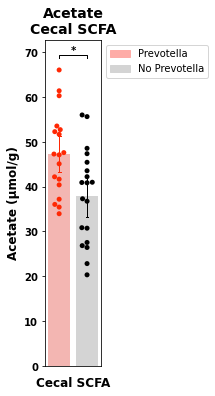

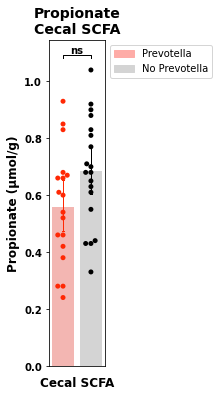

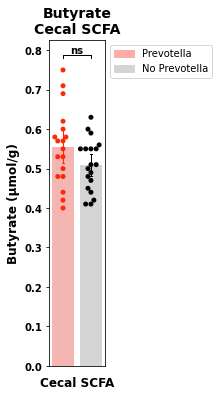

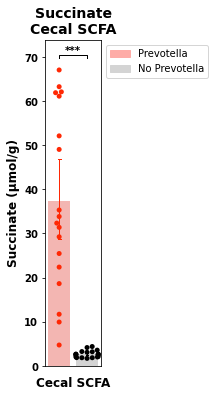

In [78]:
#SCFA
data_path = "{0}/Cecal_SCFA_data.csv".format(csv_dir)
data_df = pd.read_csv(data_path,header=0)
data_df.rename(columns=lambda x: x.strip(),inplace=True)
# data_df.rename(columns={"NEFA":"Non-Esterified Fatty Acids"},inplace=True)
# display(data_df.loc[:,"Tissue"]=="Cecal_SCFA")

SCFA_analytes = ["Acetate","Propionate","Butyrate","Succinate"]

fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/cecal/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

for analyte in SCFA_analytes:
    single_analyte_barplot(data_df,analyte=analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",sigstr_fmt="std",
                      units="µmol/g",fig_fmt=fig_fmt)


,Treatment,MouseNo,Acetate,Propionate,Butyrate,Lactate,Succinate,Arm,Mouse_ID
0,Preweaning P. copri colonization,1,55.19,0.14,0.08,0.06,36.38,1C,1C_1
1,Preweaning P. copri colonization,2,47.76,0.22,0.06,0.04,29.63,1C,1C_2
2,Preweaning P. copri colonization,3,51.66,0.13,0.04,0.06,24.81,1C,1C_3
3,Preweaning P. copri colonization,4,52.32,0.18,0.01,0.05,24.10,1C,1C_4
4,Preweaning P. copri colonization,5,57.25,0.16,0.04,0.07,29.20,1C,1C_5
5,Preweaning P. copri colonization,6,46.91,0.15,0.06,0.14,26.01,1C,1C_6
6,Preweaning P. copri colonization,7,40.40,0.09,0.05,0.07,36.60,1C,1C_7
7,Preweaning P. copri colonization,8,40.35,0.13,0.05,0.18,19.42,1C,1C_8
8,Postweaning P. copri colonization,1,42.61,0.15,0.06,0.06,34.46,1A,1A_1
9,Postweaning P. copri colonization,3,43.35,0.14,0.06,0.07,52.47,1A,1A_2


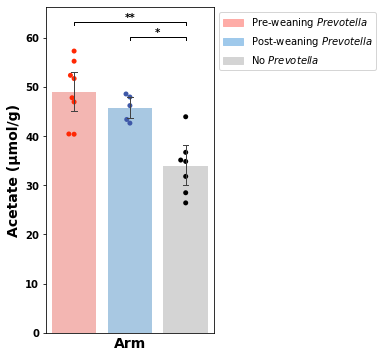

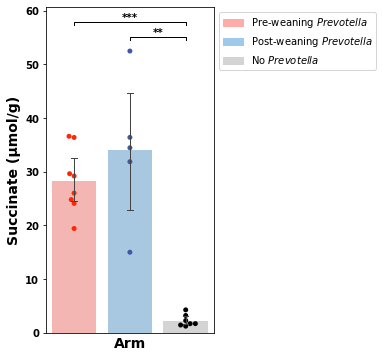

In [46]:
HWDC_og_bar_palette={"1C":"#FEACA7","1A":"#9FC9EB","2A":"#D4D4D4"}
HWDC_og_point_palette={"1C":"#FF2804","1A":"#3E58A8","2A":"#000000"}

#SCFA
data_path = "{0}/HWDC_og_cecal_SCFA.csv".format(csv_dir)
data_df = pd.read_csv(data_path,header=0)
data_df.rename(columns=lambda x: x.strip(),inplace=True)

display(data_df)
# display(data_df.loc[:,"Tissue"]=="Cecal_SCFA")

SCFA_analytes = ["Acetate","Succinate"]

fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/cecal/{0}/HWDC_og".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

for analyte in SCFA_analytes:
    stat,pval_1C,sig_str_1C = single_analyte_stats(data_df,analyte,tissue="",sampleID_col="Mouse_ID",
                                             A_group_re="1C",B_group_re="2A")
    stat,pval_1A,sig_str_1A = single_analyte_stats(data_df,analyte,tissue="",sampleID_col="Mouse_ID",
                                             A_group_re="1A",B_group_re="2A")
    fig,ax = plt.subplots(1,1,figsize=(3,6))
    sns.barplot(data=data_df,x="Arm",y=analyte,ax=ax,zorder=0,palette=HWDC_og_bar_palette,
                    capsize=0.1,errwidth=1)
    sns.swarmplot(data=data_df,x="Arm",y=analyte,ax=ax, zorder=1,
                          palette=HWDC_og_point_palette,dodge=True)
    ymin,ymax = ax.get_ylim()
    y1,y2 = ymax-(ymax-ymin)*0.01, ymax
    significance_bracket(ax,pval_1A,sig_str_1A,sigstr_fmt="std",x1=1,x2=2)
    significance_bracket(ax,pval_1C,sig_str_1C,sigstr_fmt="std",x1=0,x2=2)
    
    
    standardize_plot_style(ax,xlabel="Arm",ylabel="{0} (µmol/g)".format(analyte),title="")
    ax.set_xticks([])
    A_patch = matplotlib.patches.Patch(color=HWDC_og_bar_palette["1C"], label='Pre-weaning $\it{Prevotella}$')
    B_patch = matplotlib.patches.Patch(color=HWDC_og_bar_palette["1A"], label='Post-weaning $\it{Prevotella}$')
    C_patch = matplotlib.patches.Patch(color=HWDC_og_bar_palette["2A"], label='No $\it{Prevotella}$')
    plt.legend(handles=[A_patch,B_patch,C_patch])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
    fig_fpath = "{0}/HWDC_og_{1}.pdf".format(bar_figures_dir,analyte)
    plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)
#     single_analyte_barplot(data_df,analyte=analyte,tissue="Cecal_SCFA",sampleID_col="Mouse_ID",sigstr_fmt="std",
#                       units="µmol/g",fig_fmt=fig_fmt,A_group_re="1C")
    

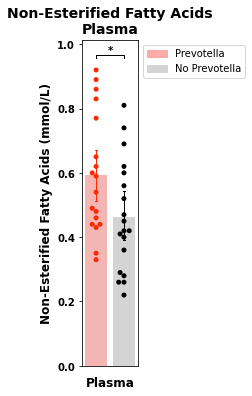

In [49]:
#NEFA 
data_path = "{0}/20220608_Lee-Chang_plasma_NEFA.csv".format(csv_dir)
data_df = pd.read_csv(data_path,header=0)
data_df.rename(columns={"NEFA":"Non-Esterified Fatty Acids"},inplace=True)


fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/plasma/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

analyte = "Non-Esterified Fatty Acids"
single_analyte_barplot(data_df,analyte=analyte,tissue="Plasma",sampleID_col="Mouse_ID",sigstr_fmt="std",
                      units="mmol/L",fig_fmt=fig_fmt)

,Mouse_ID,sample#,Sample Dilu,Ketones,Glycerol
0,MG01_AM1,1,2fold,196.82,5.80
1,MG01_AM2,2,2fold,196.84,6.00
2,MG01_AM3,3,2fold,125.12,4.74
3,MG01_AM4,4,2fold,812.76,4.06
4,MG01_AM5,5,4fold,871.90,3.56
5,MG01_AM6,6,2fold,1033.28,3.48
6,MG01_AM7,7,2fold,115.04,4.64
7,MG01_AM8,8,4fold,1965.96,2.92
8,MG01_AF1,9,4fold,292.78,6.88
9,MG01_AF2,10,2fold,210.11,4.82


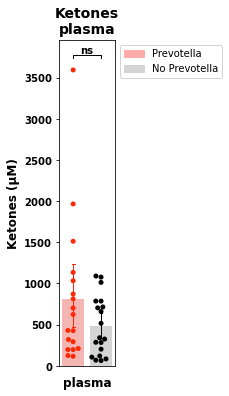

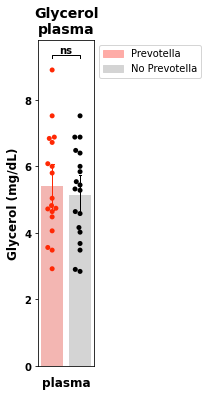

In [131]:
#Ketone and glycerol single analyte 
data_path = "{0}/20220714_plasma_KETGLYC.csv".format(csv_dir)
data_df = pd.read_csv(data_path,header=0)
data_df.rename(columns={"KET":"Ketones"},inplace=True)
display(data_df)


fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/plasma/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

single_analyte_stats(data_df,analyte_col="Ketones",tissue="plasma",sampleID_col="Mouse_ID")
single_analyte_stats(data_df,analyte_col="Glycerol",tissue="plasma",sampleID_col="Mouse_ID")

single_analyte_barplot(data_df,analyte="Ketones",tissue="plasma",sampleID_col="Mouse_ID",sigstr_fmt="std",fig_fmt="pdf")
single_analyte_barplot(data_df,analyte="Glycerol",tissue="plasma",sampleID_col="Mouse_ID",sigstr_fmt="std",
                       units="mg/dL",fig_fmt="pdf")

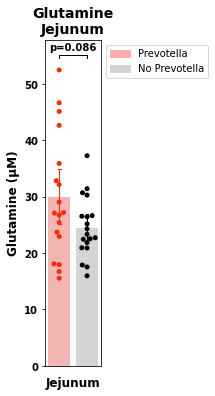

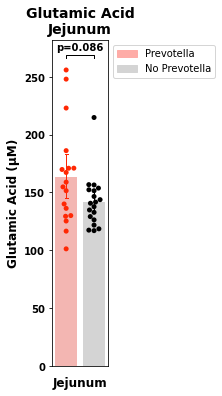

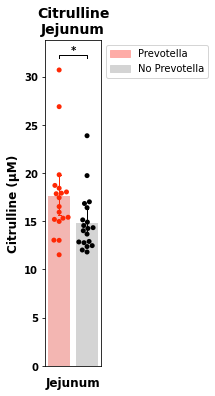

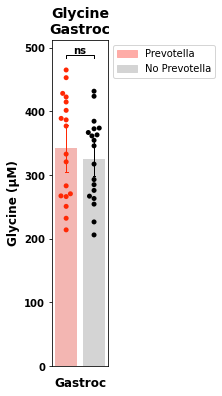

In [51]:
#Load full tissue AC and AA datasets 
plasma_AC_df = pd.read_csv("{0}/plasma_AC.csv".format(csv_dir),header=3)
tissue_amine_df = pd.read_csv("{0}/tissue_amine.csv".format(csv_dir),header=3)
tissue_AC_df = pd.read_csv("{0}/tissue_AC.csv".format(csv_dir),header=3)

tissue_amine_df.dropna(how="all",inplace=True)
tissue_amine_df.dropna(how="all",axis=1,inplace=True)
plasma_AC_df.dropna(how="all",inplace=True)

tissue_amine_df.rename(columns=lambda x: x.strip(),inplace=True)
tissue_AC_df.rename(columns=lambda x: x.strip(),inplace=True)
plasma_AC_df.rename(columns=lambda x: x.strip(),inplace=True)

#AC and amine columns 
amine_columns = tissue_amine_df.columns[4:]
AC_columns = tissue_AC_df.columns[4:]
plasma_AC_columns = plasma_AC_df.columns[7:]

#Convert to nM for consistency with HWDC original experiment data 
tissue_AC_df.loc[:,AC_columns] = tissue_AC_df.loc[:,AC_columns]*1000
tissue_amine_df.loc[:,amine_columns] = tissue_amine_df.loc[:,amine_columns]
plasma_AC_df.loc[:,plasma_AC_columns] = plasma_AC_df.loc[:,plasma_AC_columns]*1000

show_tables = False
if show_tables:
    with pd.option_context('display.max_rows',None):
        display(plasma_AC_df)
        display(tissue_amine_df)
        display(tissue_AC_df)
#Useful analyte lists 
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")
SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()    
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]    
    
analytes = soybean_ACs
fig_fmt = "pdf"
tissues = ["Jejunum"]
bar_figures_dir = "figures/analyte_bar/tissue_og_replication/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

single_analyte_barplot(tissue_amine_df,"Glutamine",tissue="Jejunum",sigstr_fmt="pval",fig_fmt=fig_fmt)
single_analyte_barplot(tissue_amine_df,"Glutamic Acid",tissue="Jejunum",sigstr_fmt="pval",fig_fmt=fig_fmt)
single_analyte_barplot(tissue_amine_df,"Citrulline",tissue="Jejunum",sigstr_fmt="std",fig_fmt=fig_fmt)
single_analyte_barplot(tissue_amine_df,"Glycine",tissue="Gastroc",sigstr_fmt="std",fig_fmt=fig_fmt)


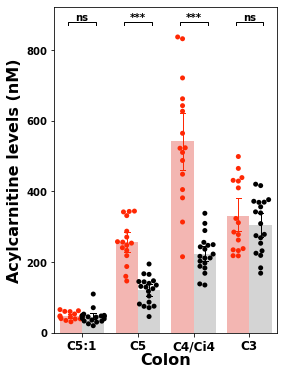

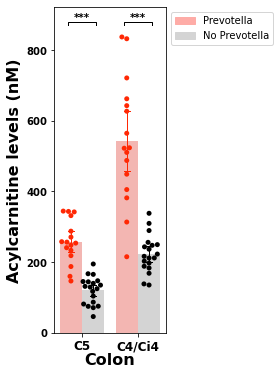

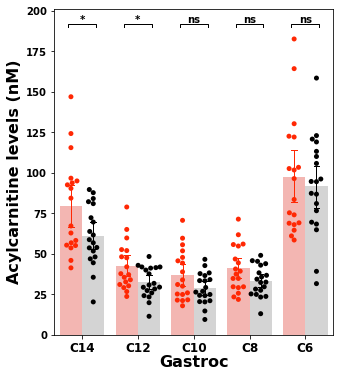

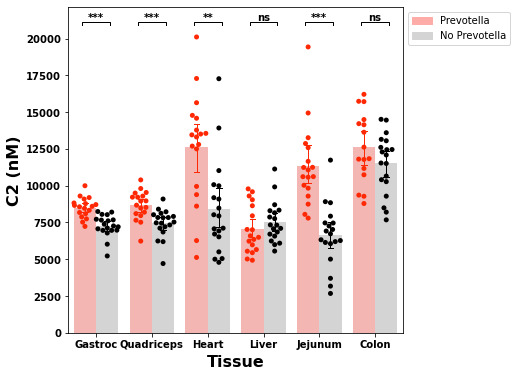

In [52]:
fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/tissue_og_replication/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
#Colon BCAA derived ACs
analytes = ["C5:1","C5","C4/Ci4","C3"]
tissues = ["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=False,fig_fmt=fig_fmt)
#Colon BCAA ACs, significant only
analytes = ["C5","C4/Ci4"]
tissues = ["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=True,fig_fmt=fig_fmt)

#Gastroc MCFA derived ACs
analytes = ["C14","C12","C10","C8","C6"]
tissues = ["Gastroc"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=False,fig_fmt=fig_fmt)

# #C2
analytes = ["C2"]
tissues = ["Gastroc","Quadriceps","Heart","Liver","Jejunum","Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=True,fig_fmt=fig_fmt)
# multiple_analyte_barplot(tissue_AC_df,analytes=analytes,tissues=tissues,A_group_re=r'AF|AM',group_col="SampleID",
#                            ax=None,units="nM",sig_strs=tissue_AC_ss.loc[analytes,tissues],legend=False)
# single_analyte_barplot(plasma_AC_df,"C2",tissue="Plasma",units="nM",sig_str=tissue_AC_ss.loc["C2","Plasma"])

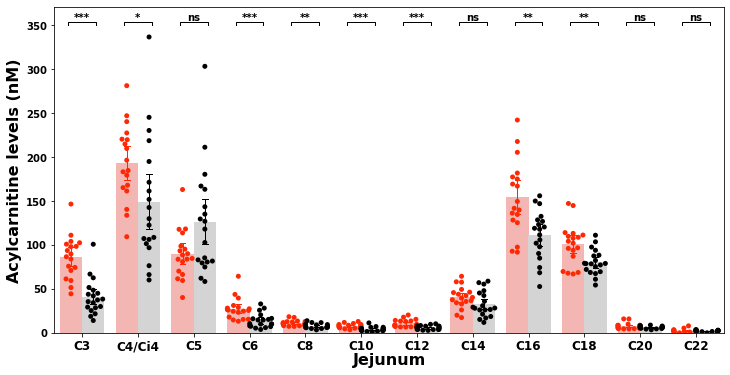

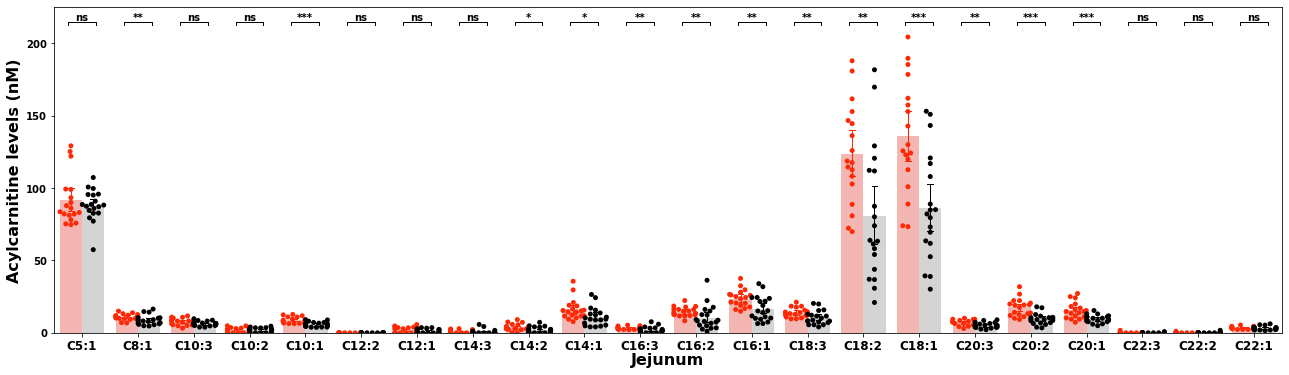

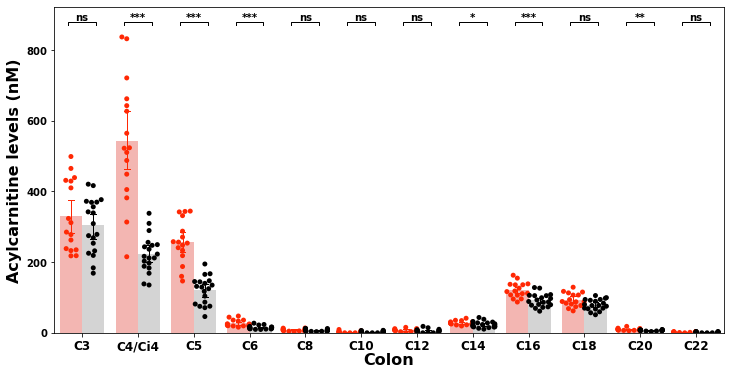

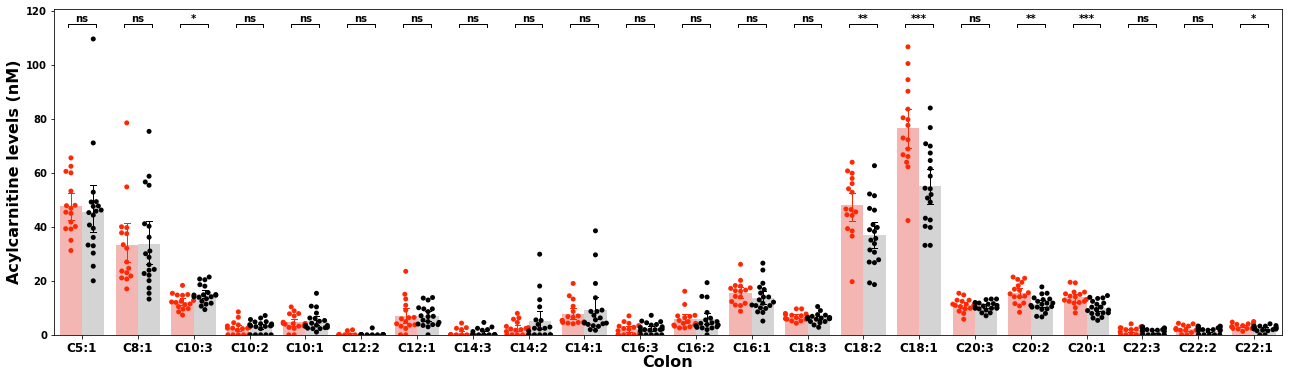

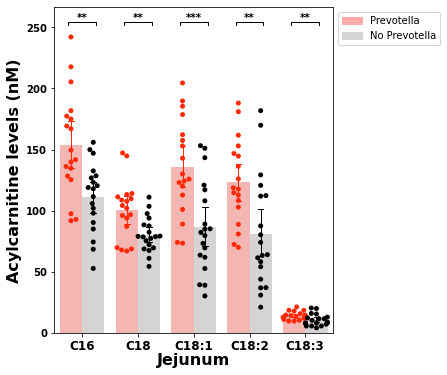

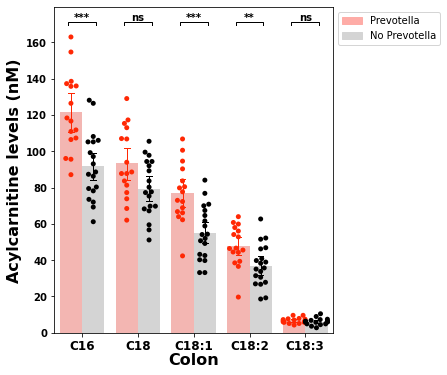

In [53]:
fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/AC_panel/intestine/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

#FA derived ACs - intestine results
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")

SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()

#SFA ACs, UFA ACs Jejunum
tissues=["Jejunum"]
multiple_analyte_barplot(tissue_AC_df,analytes=SFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
multiple_analyte_barplot(tissue_AC_df,analytes=UFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
#SFA ACs, UFA ACs Colon
tissues=["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes=SFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
multiple_analyte_barplot(tissue_AC_df,analytes=UFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)

tissues=["Jejunum"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",
                         legend=True,fig_fmt=fig_fmt)
tissues=["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",
                         legend=True,fig_fmt=fig_fmt)


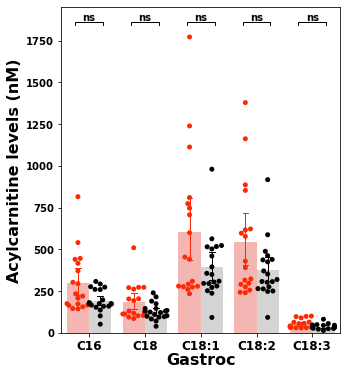

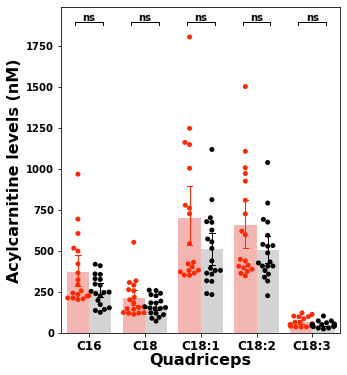

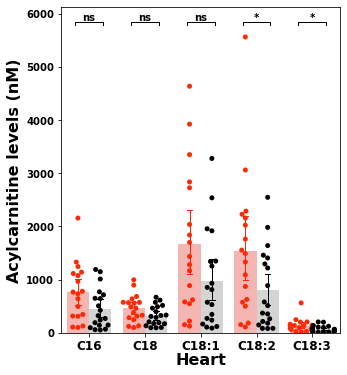

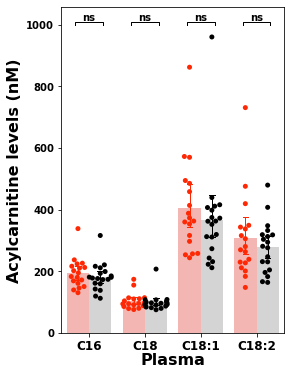

In [54]:
bar_figures_dir = "figures/analyte_bar/AC_panel/muscle"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]
soybean_4ACs = ["C16","C18","C18:1","C18:2"]
tissues=["Gastroc"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Quadriceps"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Heart"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Plasma"]
multiple_analyte_barplot(plasma_AC_df,analytes=soybean_4ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)


/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

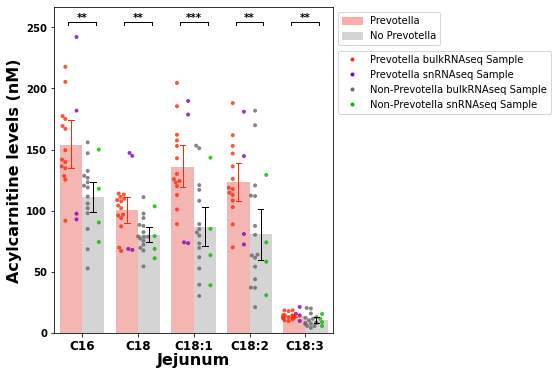

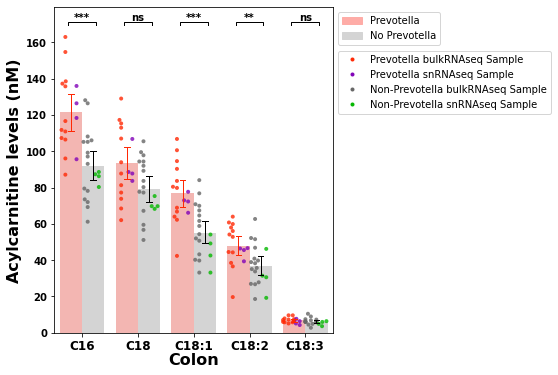

In [139]:
# outlier_hue_palette = {0:"#FF2804",1:"#5C0101",2:"#666666",3:"#000000"}
outlier_hue_palette = {0:"#FF2804",1:"#8102B8",2:"#666666",3:"#03B800"}


def multiple_analyte_barplot_mouse_hue(data_df,analytes,tissues,sampleID_map,A_group_re=r'AF|AM',sampleID_col="SampleID",
                           ax=None,units="µM",stats_test="Mann-Whitney",legend=False,sigstr_fmt="std",fig_fmt="pdf"):
    if not ax:
        plot_width = (len(analytes)*len(tissues))
        fig,ax = plt.subplots(1,1,figsize=(plot_width,6))
    long_df = tissue_analyte_long_df(data_df,analytes,tissues,sampleID_col=sampleID_col,A_group_re=A_group_re)
    long_df.loc[:,"SampleID_map"] = long_df.loc[:,sampleID_col].map(sampleID_map)
    stats_df = multiple_analyte_stats(data_df,analytes,tissues,sampleID_col=sampleID_col,
                                       A_group_re=A_group_re,stats_test=stats_test)
    pvals, sig_strs = stats_df["pval"].tolist(),stats_df["sig_str"].tolist()
    #Overlay swarmplot over barplot of individual sample data 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    if len(tissues) > 1: 
        sns.barplot(data=long_df,x="Tissue",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                capsize=0.1,errwidth=1)
        sns.swarmplot(data=long_df,x="Tissue",y="Measurement",hue="SampleID_map",ax=ax, zorder=1,
                      palette=outlier_hue_palette,dodge=True,size=5,alpha=0.8)
        ax.set_xlabel("Tissue",labelpad=5,fontsize=16,weight="bold")
        ax.set_ylabel("{0} ({1})".format(analytes[0],units),fontsize=16,weight="bold")
    else: 
        sns.barplot(data=long_df,x="Analyte",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                capsize=0.1,errwidth=1)
        sns.swarmplot(data=long_df,x="Analyte",y="Measurement",hue="SampleID_map",ax=ax, zorder=1,
                      palette=outlier_hue_palette,dodge=True,size=4,alpha=0.8)
#         sns.stripplot(data=long_df,x="Analyte",y="Measurement",hue="SampleID_map",ax=ax, zorder=1,
#                       palette=outlier_hue_palette,dodge=True,size=5,alpha=0.8)
        if units == "nM":
            ax.set_ylabel("Acylcarnitine levels ({0})".format(units),fontsize=16,weight="bold")
        elif units == "µM":
            ax.set_ylabel("Amine levels ({0})".format(units),fontsize=16,weight="bold")
        ax.set_xlabel(tissues[0],labelpad=0,fontsize=16,weight="bold")

    #spaghetti code for changing error bar hues on seaborns barplot 
    face_colors = list(HWDC_bar_palette.values())
    point_colors = list(HWDC_point_palette.values())
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        color_index = i//(lines_per_err*len(tissues)*len(analytes))
        newcolor = point_colors[color_index]
        line.set_color(newcolor)
    #Matplotlib formatting 
    xtick_labels = ax.get_xticklabels()
    if len(analytes) > 1:
        ax.set_xticklabels(xtick_labels,fontsize=12,weight="bold")
    #bold xtick/yticks
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    #Sig String annotation and brackets 
    if len(analytes) > 1:
        items = analytes
    else:
        items = tissues
    xticks = ax.get_xticks()
    ymin,ymax = ax.get_ylim()
    ydiff = ymax-ymin
    y1, y2 = ymax-ydiff*0.01,ymax
    for i,item in enumerate(items):
        x1, x2 = xticks[i]-0.25,xticks[i]+0.25
        pval,sig_str = pvals[i], sig_strs[i]
        significance_bracket(ax,pval,sig_str,sigstr_fmt=sigstr_fmt,x1=x1,x2=x2,y1=y1,y2=y2)
    if legend:
        A_patch = matplotlib.patches.Patch(color=face_colors[0], label='Prevotella')
        B_patch = matplotlib.patches.Patch(color=face_colors[1], label='No Prevotella')
        plt.legend(handles=[A_patch,B_patch])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
        plt.gca().add_artist(ax.get_legend())
        #Second legend - outlier sample labels 
        outlier_labels = ["Prevotella bulkRNAseq Sample","Prevotella snRNAseq Sample",
                         "Non-Prevotella bulkRNAseq Sample","Non-Prevotella snRNAseq Sample"]
        outlier_handles = [matplotlib.lines.Line2D([],[],color=c,marker="o",linestyle='None',markersize=3,
                                          label=outlier_labels[i]) for i,c in enumerate(outlier_hue_palette.values())]
        ax.legend(handles=outlier_handles)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.88)) 
        
        
    else:
        ax.get_legend().remove() #remove legend
    if len(analytes) > 6:
        analytes = analytes[:3] +["..."]+ analytes[-3:]
    tissues_path_str = ".".join(tissues)
    analyte_path_str = ",".join(analytes).replace("/","").replace(":","_")
#         analyte_path_str = analyte.replace('/','.')
    figure_path = "{0}/{1}_{2}_outlier.{3}".format(bar_figures_dir,analyte_path_str,tissues_path_str,fig_fmt)
    plt.savefig(figure_path,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)
    
    
fig_fmt="pdf"
bar_figures_dir = "figures/analyte_bar/AC_panel/intestine/{0}".format(fig_fmt)
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
    
#Jej Cluster 1, Skm cluster 0; Jej0, skm 0 
A_outliers = ["MG01_AM7","MG01_AF3","MG01_AM6","MG01_AF6"]
#Jej Cluster 3, Skm cluster 2; Jej2, skm 2
B_outliers = ["MG01_BM4","MG01_BF4","MG01_BM7","MG01_BF10"]
sampleIDs = tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Jejunum","SampleID"]
default_sampleID_map = dict(zip(sampleIDs.tolist(),[0]*18+[2]*19))
for A_out in A_outliers:
    default_sampleID_map[A_out] = 1 
for B_out in B_outliers:
    default_sampleID_map[B_out] = 3 
# sampleIDs = sampleIDs.reindex(sampleIDs.values)
sampleID_map_col = sampleIDs.map(default_sampleID_map)
sampleID_map_col = sampleID_map_col.set_axis(sampleIDs)

# display(tissue_AC_df.loc[tissue_AC_df["Tissue"]=="Jejunum"],["SampleID"]+soybean_ACs)
tissues=["Jejunum"]
multiple_analyte_barplot_mouse_hue(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sampleID_map=default_sampleID_map,
                                   sigstr_fmt="std",units="nM",
                         legend=True,fig_fmt=fig_fmt)
tissues=["Colon"]
multiple_analyte_barplot_mouse_hue(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sampleID_map=default_sampleID_map,
                                   sigstr_fmt="std",units="nM",
                         legend=True,fig_fmt=fig_fmt)

In [147]:
#Ketone and glycerol single analyte 
kg_path = "{0}/20220714_plasma_KETGLYC.csv".format(csv_dir)
kg_df = pd.read_csv(kg_path,header=0)
kg_df.rename(columns={"KET":"Ketones"},inplace=True)
display(kg_df.loc[kg_df["Mouse_ID"].isin(A_outliers+B_outliers)])
# display(kg_df.loc[~kg_df["Mouse_ID"].isin(A_outliers+B_outliers)])

,Mouse_ID,sample#,Sample Dilu,Ketones,Glycerol
5,MG01_AM6,6,2fold,1033.28,3.48
6,MG01_AM7,7,2fold,115.04,4.64
10,MG01_AF3,11,2fold,429.54,6.72
12,MG01_AF6,13,4fold,623.40,4.72
21,MG01_BM4,22,2fold,282.86,2.84
24,MG01_BM7,25,4fold,105.65,3.48
30,MG01_BF4,31,4fold,324.92,5.32
36,MG01_BF10,37,4fold,119.55,6.48
